<a href="https://colab.research.google.com/github/abhishek1998s/Encryptix/blob/main/SMS_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
   from google.colab import files
   files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"abhishekkumarsing98","key":"446ba7a4cf4d49511a4db1a936da536c"}'}

In [3]:
   !mkdir -p ~/.kaggle
   !cp kaggle.json ~/.kaggle/
   !chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
100% 211k/211k [00:00<00:00, 751kB/s]
100% 211k/211k [00:00<00:00, 750kB/s]


In [5]:
!unzip sms-spam-collection-dataset

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [7]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
# Load the dataset
data = pd.read_csv('/content/spam.csv', encoding='latin1')
data.sample(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2675,ham,I'm sick !! I'm needy !! I want you !! *pouts*...,NaN,NaN,NaN
4071,spam,Loans for any purpose even if you have Bad Cre...,NaN,NaN,NaN
1138,ham,What * u wearing?,NaN,NaN,NaN
2841,ham,aathi..where are you dear..,NaN,NaN,NaN
5325,ham,Gal n boy walking in d park. gal-can i hold ur...,NaN,NaN,NaN
703,ham,"Thats a bit weird, even ?- where is the do sup...",NaN,NaN,NaN
1778,ham,7 wonders in My WORLD 7th You 6th Ur style 5th...,NaN,NaN,NaN
3335,ham,Then u go back urself lor...,NaN,NaN,NaN
2025,ham,"Yes obviously, but you are the eggs-pert and t...",NaN,NaN,NaN
4771,ham,"Hi, Mobile no. &lt;#&gt; has added you in th...",NaN,NaN,NaN


In [13]:
# Drop unnecessary columns and rename relevant ones
data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
data.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)
data.sample(10)

,target,text
848,ham,Yeah there's barely enough room for the two of...
2170,ham,\CAN I PLEASE COME UP NOW IMIN TOWN.DONTMATTER...
3124,spam,1st wk FREE! Gr8 tones str8 2 u each wk. Txt N...
633,ham,Got it. Seventeen pounds for seven hundred ml ...
138,spam,You'll not rcv any more msgs from the chat svc...
862,ham,"Sorry, I guess whenever I can get a hold of my..."
5513,ham,Yes. Please leave at &lt;#&gt; . So that at ...
1916,ham,Fffff. Can you text kadeem or are you too far ...
1969,spam,You have won a guaranteed å£200 award or even ...
2172,ham,Yavnt tried yet and never played original either


In [14]:
# Check for missing values and duplicates
print("Missing values:\n", data.isnull().sum())
print("Duplicate values:", data.duplicated().sum())

Missing values:
 target    0
text      0
dtype: int64
Duplicate values: 403


In [15]:
# Encode the target variable (ham = 0, spam = 1)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['target'] = encoder.fit_transform(data['target'])

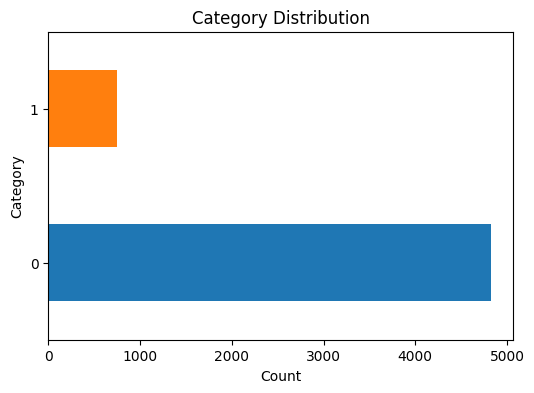

In [17]:
# Visualize the category distribution
plt.figure(figsize=(6, 4))
data['target'].value_counts().plot(
    kind='barh',
    color=['#1f77b4', '#ff7f0e']  # Blue for Ham, Orange for Spam
)
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Category Distribution')
plt.show()

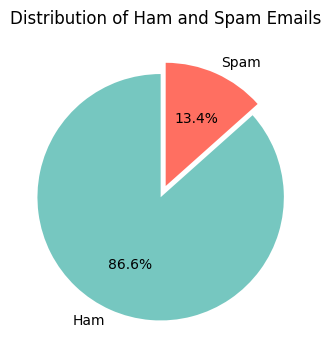

In [18]:
# Pie chart for spam vs ham distribution
counts = data['target'].value_counts()
labels = ['Ham', 'Spam']
colors = ['#76c7c0', '#ff6f61']  # Teal for Ham, Coral for Spam
plt.figure(figsize=(4, 4))
plt.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.1, 0)  # Slightly explode the Ham slice
)
plt.title('Distribution of Ham and Spam Emails')
plt.show()

In [19]:
# Text preprocessing
lemmatizer = WordNetLemmatizer()
documents = []

In [20]:
for sen in range(0, len(data['text'])):
    # Remove non-alphanumeric characters
    document = re.sub(r'\W', ' ', str(data['text'][sen]))
    # Remove single characters and extra spaces
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    document = re.sub(r'^b\s+', '', document)
    # Convert to lowercase
    document = document.lower()
    # Lemmatize the text
    document = ' '.join([lemmatizer.lemmatize(word) for word in document.split()])
    documents.append(document)

In [21]:
# TF-IDF Vectorization
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(documents).toarray()
y = data['target']

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
# Train a Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [24]:
# Make predictions
y_pred = classifier.predict(X_test)

In [25]:
# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[948   1]
 [ 19 147]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       949
           1       0.99      0.89      0.94       166

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Accuracy Score: 0.9820627802690582


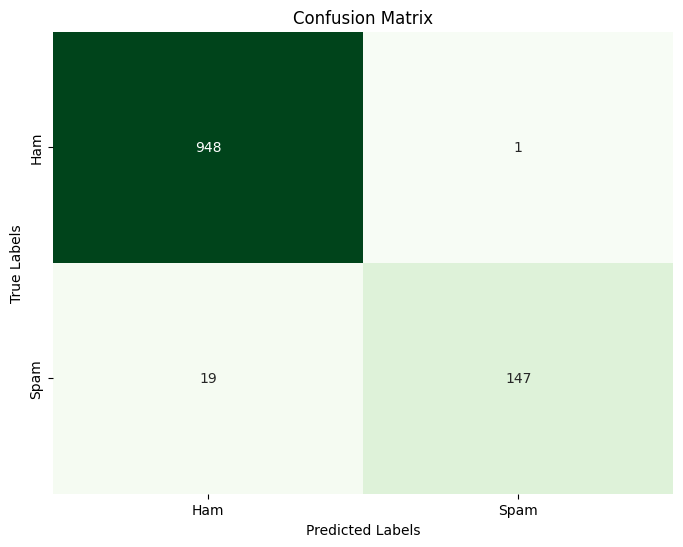

In [26]:
# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Greens',  # Green color palette
    cbar=False,
    xticklabels=['Ham', 'Spam'],
    yticklabels=['Ham', 'Spam']
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

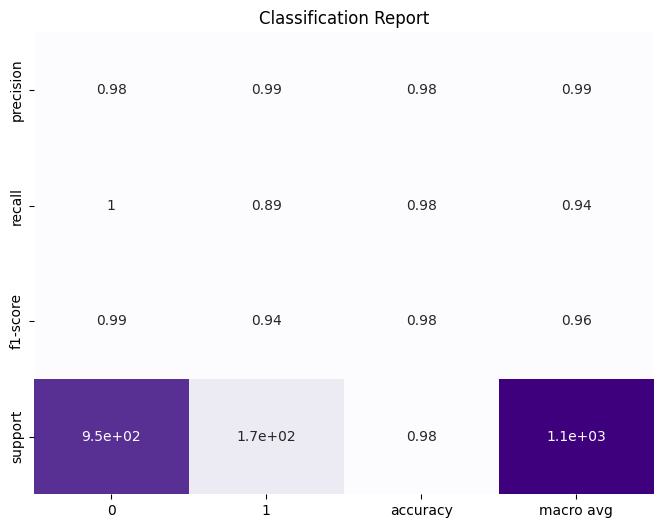

In [27]:
# Visualize the classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(8, 6))
sns.heatmap(
    report_df.iloc[:-1, :].T,
    annot=True,
    cmap='Purples',  # Purple color palette
    cbar=False
)
plt.title('Classification Report')
plt.show()